Stainless Steel Data Set
http://www.worldstainless.org/statistics/foreign_trade_stainless_scrap

Confidence Intervals
https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

Quantile Predictors 
https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb


http://freerangestats.info/blog/2016/12/07/arima-prediction-intervals

For Linear Regression
https://machinelearningmastery.com/prediction-intervals-for-machine-learning/



In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

import os
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
print("Current Working Directory " , os.getcwd())
os.chdir('documents/github/metals-research/forecasting')

print("Current Working Directory " , os.getcwd())


Current Working Directory  C:\Users\ckato\Documents\GitHub\metals-research\forecasting


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'documents/github/metals-research/forecasting'

In [2]:
os.chdir('../')

# Connecting to Engine
engine = create_engine('sqlite:///metals_dashboard.sqlite')

connection = engine.connect()

# What's in the database already?

print(engine.table_names())


['EVSales', 'M3E1', 'M3E3', 'MS', 'MX', 'baselines', 'battery_cap', 'cell18650H', 'cell2170C', 'cellM48', 'commodities', 'fastmarkets', 'lithium_benchmark_fastmarkets', 'platts_hydroxide', 'platts_hydroxide_avg', 'usage']


In [3]:
comm = pd.read_sql_query('SELECT * from commodities;', connection)
comm.index = pd.to_datetime(comm['Date'])
os.chdir('forecasting')


In [64]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [65]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [46]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled


#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [135]:
# Rolling Average from last 8 weeks
window_setting= 5*1
LME_stationary = preprocess(LME, window_setting)


total_nickel_station = preprocess(total_nickel, window_setting)
brisquette_nickel_station = preprocess(brisquette_nickel, window_setting)
other_nickel_station = preprocess(other_nickel, window_setting)

rcParams['figure.figsize'] = 9, 6

#test_stationarity(LME_stationary.dropna())

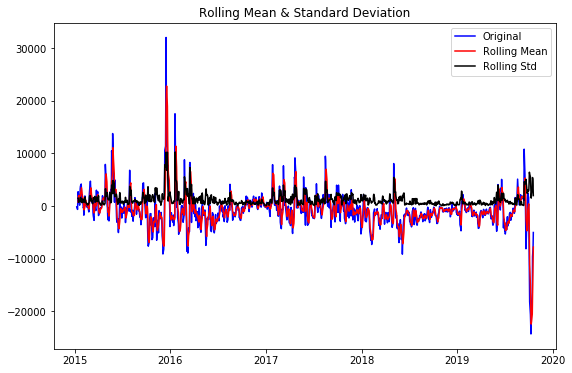

Results of Dickey-Fuller Test:
Test Statistic                   -3.973647
p-value                           0.001555
#Lags Used                       23.000000
Number of Observations Used    1222.000000
Critical Value (1%)              -3.435713
Critical Value (5%)              -2.863908
Critical Value (10%)             -2.568031
dtype: float64


In [136]:
test_stationarity(total_nickel_station.dropna())

In [137]:
LME_stationary = preprocess(LME, window_setting)

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df.index = df['ds']
df = df.iloc[:, 1:]


df['y'] = df['lag0'].shift(-261)
df = df.dropna()
df.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,y
ds,,,,,,,,,,,,
2000-10-16,-558.0,-106.7,24.0,79.8,-69.0,10.8,233.0,-189.4,292.0,336.3,-168.90,-151.7
2000-10-17,-528.0,-294.3,395.0,-38.2,23.0,-1274.6,107.0,-217.4,69.4,73.9,-176.90,-162.4
2000-10-18,-346.0,-75.7,438.0,-396.8,124.0,-1082.6,-135.0,-148.4,-81.0,198.5,13.30,-418.4
2000-10-19,-95.0,88.9,307.0,-238.0,215.0,-459.6,-183.0,-177.2,143.0,537.9,-44.00,-552.8
2000-10-20,91.2,283.3,298.0,-358.2,310.0,-204.0,-65.4,-662.2,140.0,604.9,0.56,-433.4


In [138]:
X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
y= df['y']

X_test = X.loc['2017-10-14':,:]
y_test = y['2017-10-14':]

X_train = X.loc[:'2017-10-14', :]
y_train = y[:'2017-10-14']


X_train.tail()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
ds,,,,,,,,,,,
2017-10-09,465.1,-292.65,-237.6,373.7,146.55,177.7,-186.90,-283.40,196.85,60.80,-191.30
2017-10-10,391.1,19.55,-355.4,433.6,-80.85,92.8,-25.15,21.85,150.60,344.30,-222.85
2017-10-11,382.0,-591.85,111.2,172.9,97.15,-198.6,-119.15,105.15,173.00,606.35,187.00
2017-10-12,551.2,-571.45,77.4,-72.0,98.25,-233.9,10.70,197.25,-120.45,643.35,238.30
2017-10-13,645.7,-493.50,388.9,-103.7,126.25,-167.2,156.10,64.50,50.45,275.65,153.65


### For Confidence Intervals - Create Upper and Lower Prediction Intervals

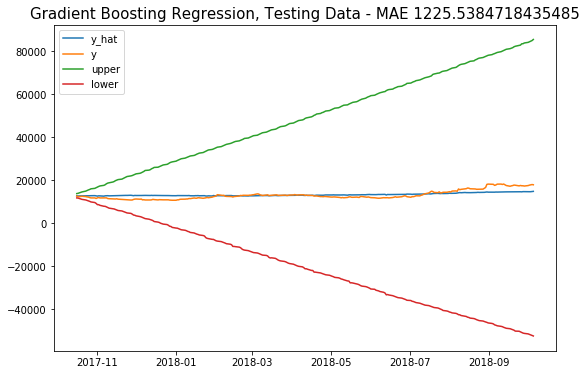

In [139]:
'''Upper Inteverval Pred'''
alpha = 0.95

upper =  GradientBoostingRegressor(loss='quantile', alpha=alpha)
regressor = upper

regressor.fit(X_train, y_train)

upper_y_pred = regressor.predict(X_test)
upper_y_pred = pd.Series(upper_y_pred)

upper_y_pred = unscale(upper_y_pred, original_tail, window_setting)
upper_y_pred.index = y_test.index


############

'''Lower Inteverval Pred'''
alpha = 1-alpha 
lower =  GradientBoostingRegressor(loss='quantile', alpha=alpha)
regressor = lower

regressor.fit(X_train, y_train)

lower_y_pred = regressor.predict(X_test)
lower_y_pred = pd.Series(lower_y_pred)
lower_y_pred = unscale(lower_y_pred, original_tail, window_setting)

lower_y_pred.index = y_test.index


############
'''Middle Inteverval Pred'''

middle =  GradientBoostingRegressor(loss='ls')
regressor = middle

regressor.fit(X_train, y_train)

middle_y_pred = regressor.predict(X_test)
middle_y_pred = pd.Series(middle_y_pred)
middle_y_pred.index = y_test.index

middle_y_pred = unscale(middle_y_pred, original_tail, window_setting)
unscaled =middle_y_pred
unscaled.index = y_test.index

##################

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index


original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_pred_train[window_setting:].index

###########


plt.plot(unscaled)
plt.plot(original_y)
plt.plot(upper_y_pred)
plt.plot(lower_y_pred)
plt.legend(['y_hat', 'y', 'upper', 'lower'])
plt.title('Gradient Boosting Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/gradient_boost_all_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
plt.savefig(filename)
plt.show()


{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 50}
Mean Absolute Error: 1422.9494851795585
Mean Squared Error: 3841639.5197258843
Root Mean Squared Error: 1960.0100815367978

{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Mean Absolute Error: 1421.9708672263814
Mean Squared Error: 3827868.4108393043
Root Mean Squared Error: 1956.493907692867

{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 150}
Mean Absolute Error: 1421.0278058205047
Mean Squared Error: 3814262.3539507054
Root Mean Squared Error: 1953.01365943782

{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 200}
Mean Absolute Error: 1420.0894481876194
Mean Squared Error: 3800819.5669246027
Root Mean Squared Error: 1949.569072109168

{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 250}
Mean Absolute Error: 1419.1557708663927
Mean Squared Error: 3787538.28605

Mean Absolute Error: 1410.8878585795578
Mean Squared Error: 3673537.8100370397
Root Mean Squared Error: 1916.6475445519554

{'learning_rate': 0.0001, 'loss': 'huber', 'min_samples_leaf': 0.05, 'n_estimators': 50}
Mean Absolute Error: 1412.8094050734783
Mean Squared Error: 3691397.1122101494
Root Mean Squared Error: 1921.3008905973445

{'learning_rate': 0.0001, 'loss': 'huber', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Mean Absolute Error: 1411.8882011337732
Mean Squared Error: 3682104.763614966
Root Mean Squared Error: 1918.8811228460627

{'learning_rate': 0.0001, 'loss': 'huber', 'min_samples_leaf': 0.05, 'n_estimators': 150}
Mean Absolute Error: 1410.9770616046371
Mean Squared Error: 3672894.7365903435
Root Mean Squared Error: 1916.479777245339

{'learning_rate': 0.0001, 'loss': 'huber', 'min_samples_leaf': 0.05, 'n_estimators': 200}
Mean Absolute Error: 1410.082843041741
Mean Squared Error: 3663767.525112757
Root Mean Squared Error: 1914.097052166571

{'learning_rate': 0.0001, 

Mean Absolute Error: 1396.7449389604683
Mean Squared Error: 3526288.3946291483
Root Mean Squared Error: 1877.8414189247046

{'learning_rate': 0.001, 'loss': 'ls', 'min_samples_leaf': 1, 'n_estimators': 250}
Mean Absolute Error: 1391.4036551491245
Mean Squared Error: 3447008.9832156524
Root Mean Squared Error: 1856.6122328627625

{'learning_rate': 0.001, 'loss': 'lad', 'min_samples_leaf': 0.05, 'n_estimators': 50}
Mean Absolute Error: 1409.6504499515856
Mean Squared Error: 3653706.4557257053
Root Mean Squared Error: 1911.4670951197945

{'learning_rate': 0.001, 'loss': 'lad', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Mean Absolute Error: 1406.4203731790249
Mean Squared Error: 3614277.666269547
Root Mean Squared Error: 1901.1253683725192

{'learning_rate': 0.001, 'loss': 'lad', 'min_samples_leaf': 0.05, 'n_estimators': 150}
Mean Absolute Error: 1404.8530162241739
Mean Squared Error: 3616620.2403344116
Root Mean Squared Error: 1901.7413705166146

{'learning_rate': 0.001, 'loss': 'lad'

Mean Absolute Error: 1391.7609948997858
Mean Squared Error: 3504868.10735985
Root Mean Squared Error: 1872.1292977141964

{'learning_rate': 0.001, 'loss': 'huber', 'min_samples_leaf': 1, 'n_estimators': 250}
Mean Absolute Error: 1387.8717186408076
Mean Squared Error: 3462525.7834575595
Root Mean Squared Error: 1860.7863347137843

{'learning_rate': 0.01, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 50}
Mean Absolute Error: 1367.429310488796
Mean Squared Error: 3042748.7316421913
Root Mean Squared Error: 1744.3476521732105

{'learning_rate': 0.01, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Mean Absolute Error: 1351.047326046958
Mean Squared Error: 2779304.9654665994
Root Mean Squared Error: 1667.1247600184574

{'learning_rate': 0.01, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 150}
Mean Absolute Error: 1328.56218124835
Mean Squared Error: 2596640.604526813
Root Mean Squared Error: 1611.4095086373336

{'learning_rate': 0.01, 'loss': 'ls', 'min_samp

Mean Absolute Error: 1362.2929246439674
Mean Squared Error: 3136904.1264644493
Root Mean Squared Error: 1771.1307479868474

{'learning_rate': 0.01, 'loss': 'lad', 'min_samples_leaf': 1, 'n_estimators': 250}
Mean Absolute Error: 1355.3010478260078
Mean Squared Error: 3070586.015378102
Root Mean Squared Error: 1752.3087671349767

{'learning_rate': 0.01, 'loss': 'huber', 'min_samples_leaf': 0.05, 'n_estimators': 50}
Mean Absolute Error: 1359.8644281055738
Mean Squared Error: 3121351.137011472
Root Mean Squared Error: 1766.7345972192518

{'learning_rate': 0.01, 'loss': 'huber', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Mean Absolute Error: 1344.5828287944516
Mean Squared Error: 2831323.110708106
Root Mean Squared Error: 1682.653592011174

{'learning_rate': 0.01, 'loss': 'huber', 'min_samples_leaf': 0.05, 'n_estimators': 150}
Mean Absolute Error: 1331.5476947218717
Mean Squared Error: 2684664.37969366
Root Mean Squared Error: 1638.494546739067

{'learning_rate': 0.01, 'loss': 'huber', 

Mean Absolute Error: 1231.9458662374943
Mean Squared Error: 2364352.693077427
Root Mean Squared Error: 1537.6451778864416

{'learning_rate': 0.1, 'loss': 'ls', 'min_samples_leaf': 1, 'n_estimators': 250}
Mean Absolute Error: 1232.3744117097212
Mean Squared Error: 2312024.329870389
Root Mean Squared Error: 1520.5342251558789

{'learning_rate': 0.1, 'loss': 'lad', 'min_samples_leaf': 0.05, 'n_estimators': 50}
Mean Absolute Error: 1299.2016072462618
Mean Squared Error: 3037547.610693723
Root Mean Squared Error: 1742.8561646601026

{'learning_rate': 0.1, 'loss': 'lad', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Mean Absolute Error: 1298.4480255382427
Mean Squared Error: 3137596.2174847657
Root Mean Squared Error: 1771.3261183319028

{'learning_rate': 0.1, 'loss': 'lad', 'min_samples_leaf': 0.05, 'n_estimators': 150}
Mean Absolute Error: 1294.1782248761547
Mean Squared Error: 3154652.158147427
Root Mean Squared Error: 1776.1340484736581

{'learning_rate': 0.1, 'loss': 'lad', 'min_sample

Mean Absolute Error: 1253.317464822497
Mean Squared Error: 2531221.5931568765
Root Mean Squared Error: 1590.9813302351718

{'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 1, 'n_estimators': 250}
Mean Absolute Error: 1274.060532333975
Mean Squared Error: 2534897.064883934
Root Mean Squared Error: 1592.1360070307855

Adaboost CV Results
{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 50} 1422.9494851795585
{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 100} 1421.9708672263814
{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 150} 1421.0278058205047
{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 200} 1420.0894481876194
{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.05, 'n_estimators': 250} 1419.1557708663927
{'learning_rate': 0.0001, 'loss': 'ls', 'min_samples_leaf': 0.25, 'n_estimators': 50} 1423.6943915404008
{'learning_rate':

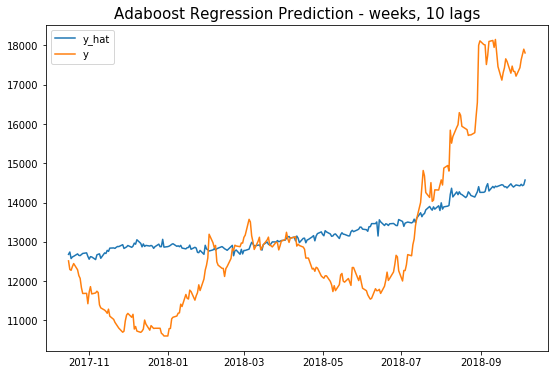

In [144]:
params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250],
                            'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                           'loss': ['ls', 'lad', 'huber'],
                            'min_samples_leaf': [ .05, .25, .45, 1]        
                       })

cv_results = {}

for params in params1:
    
    regressor = GradientBoostingRegressor(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    unscaled = unscale(y_pred, original_tail, window_setting)
    unscaled.index = y_test.index

    original_y = unscale(y_test, original_tail, window_setting)
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Adaboost CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test Accuracy: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()

In [ ]:
'''Upper Inteverval Pred'''
alpha = 0.95

upper =  GradientBoostingRegressor(loss='quantile', alpha=alpha)
regressor = upper

regressor.fit(X_train, y_train)

upper_y_pred = regressor.predict(X_test)
upper_y_pred = pd.Series(upper_y_pred)

upper_y_pred = unscale(upper_y_pred, original_tail, window_setting)
upper_y_pred.index = y_test.index


############

'''Lower Inteverval Pred'''
alpha = 1-alpha 
lower =  GradientBoostingRegressor(loss='quantile', alpha=alpha)
regressor = lower

regressor.fit(X_train, y_train)

lower_y_pred = regressor.predict(X_test)
lower_y_pred = pd.Series(lower_y_pred)
lower_y_pred = unscale(lower_y_pred, original_tail, window_setting)

lower_y_pred.index = y_test.index


############
'''Middle Inteverval Pred'''

middle =  GradientBoostingRegressor(loss='ls')
regressor = middle

regressor.fit(X_train, y_train)

middle_y_pred = regressor.predict(X_test)
middle_y_pred = pd.Series(middle_y_pred)
middle_y_pred.index = y_test.index

middle_y_pred = unscale(middle_y_pred, original_tail, window_setting)
unscaled =middle_y_pred
unscaled.index = y_test.index

##################

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index


original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_pred_train[window_setting:].index

###########


plt.plot(unscaled)
plt.plot(original_y)
plt.plot(upper_y_pred)
plt.plot(lower_y_pred)
plt.legend(['y_hat', 'y', 'upper', 'lower'])
plt.title('Gradient Boosting Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/gradient_boost_all_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
plt.savefig(filename)
plt.show()

## Linear Regression

IMPORTANT NOTE TO SELF: 
For smoothing using moving average, must RESCALE output predictions using inputs!! 

SECOND NOTE 2 SELF: 
for training/fitting/testing set... 

MODEL FOR DEPLOYMENT: 
Train a model that uses values from a year ago or OLDER to predict values and rescale according to moving averages... 



In [95]:
# NOTE: Fix if overlapping
#X_train = X.loc[:'2017-10-07', :]
#y_train = y[:'2017-10-07']


In [15]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)
print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index


# y_pred = y_pred.reindex(X_test.index)

[-0.04208122 -0.05808713 -0.04413515  0.01459916  0.01221141 -0.01436705
 -0.02467037  0.01931146 -0.03247286 -0.02821095  0.00549395]


## Back to Scale before Performance Analysis

In [88]:
LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############


ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64


In [89]:
original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_pred_train[window_setting:].index

print(original_y_train.head())

ds
2000-12-04    5360.0
2000-12-05    5370.0
2000-12-06    5302.0
2000-12-07    5135.0
2000-12-08    4960.0
dtype: float64


In [18]:
# Sanity check for unscaling! 

LME_shifted[LME_shifted.index=='2017-10-16']


#LME[LME.index=='2018-10-31']

Unnamed: 1
2017-10-16    12516.5
Freq: B, Name: Cash Price ($/MT), dtype: float64

In [19]:
# Sanity Check
LME_shifted[LME_shifted.index=='2000-12-04']


Unnamed: 1
2000-12-04    5360.0
Freq: B, Name: Cash Price ($/MT), dtype: float64

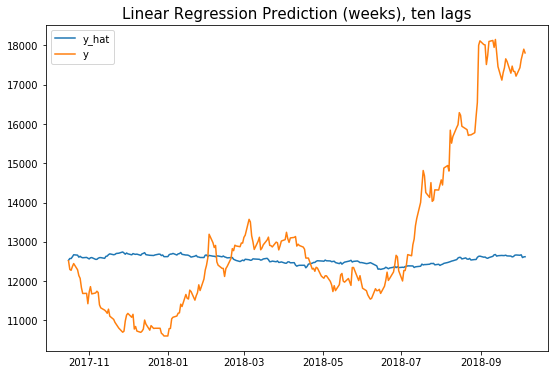

Mean Absolute Error: 1482.2832147704032
Mean Squared Error: 4434537.137121758
Root Mean Squared Error: 2105.8340716024513


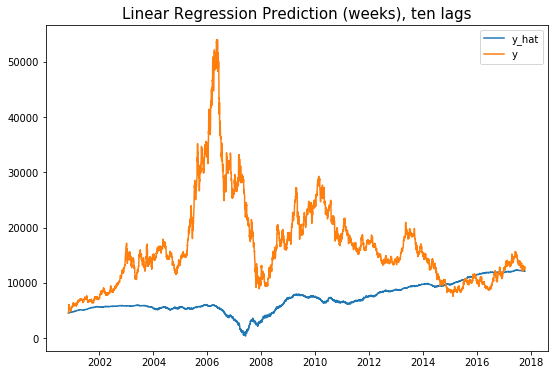

Mean Absolute Error: 9664.785320949642
Mean Squared Error: 171540238.86200202
Root Mean Squared Error: 13097.337090492938


In [20]:
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


# Other Kinds of Regression

Grid Search for RIDGE Regression

# MAIN GOOD ONES
Knn K=6 
2 week lags at 3 week rolling average windows 

Knn K=7
4 week lags at 4 week rolling average windows 

Polynomial 
4 month lags 8 week rolling average windows


ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64
ds
2000-11-06    4521.0
2000-11-07    4532.0
2000-11-08    4614.0
2000-11-09    4891.0
2000-11-10    5499.5
dtype: float64


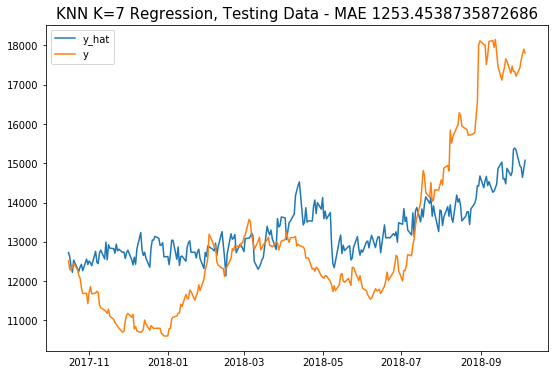

Mean Absolute Error: 1253.4538735872686
Mean Squared Error: 2347471.5514717815
Root Mean Squared Error: 1532.1460607500126


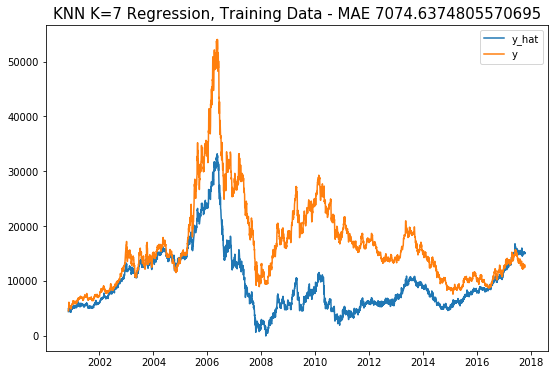

Mean Absolute Error: 7074.6374805570695
Mean Squared Error: 84440250.35487752
Root Mean Squared Error: 9189.137628465334


In [48]:
K = 7
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
regressor.fit(X_train, y_train)

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_pred_train[window_setting:].index

print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K) +' Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


In [20]:
# Try Gradient Boosting Regression

# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

# Fit models
lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)
# Record actual values on test set
predictions = pd.DataFrame(y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

predictions.head()


,y,lower,mid,upper
ds,,,,
2017-10-16,-62.20,-874.642532,114.842214,997.928527
2017-10-17,-289.75,-721.152494,28.512810,902.413903
2017-10-18,-274.40,-734.744849,-101.368620,876.802153
2017-10-19,-165.75,-734.744849,-40.846368,876.802153
2017-10-20,-73.55,-724.623150,-40.846368,840.502153


In [27]:
# Sanity Check
LME_shifted[LME_shifted.index=='2000-11-06']

LME_shifted[LME_shifted.index=='2017-10-16']



Unnamed: 1
2017-10-16    12516.5
Freq: B, Name: Cash Price ($/MT), dtype: float64

In [ ]:
middle =  GradientBoostingRegressor(loss='ls')
regressor = middle

regressor.fit(X_train, y_train)

middle_y_pred = regressor.predict(X_test)
middle_y_pred = pd.Series(middle_y_pred)
middle_y_pred.index = y_test.index

middle_y_pred = unscale(middle_y_pred, original_tail, window_setting)


